# Task : Use device sensor log data to experiment whether ML based model can predict device failure

**Device maintenance Task**

Given a data set containing data collected from sensors that are monitoring a certain device a stakeholder perceived the need to improve the maintenance of this device.
He approached you and described the Business case as:

We have this data and I understand that we need to improve the way we schedule the maintenance for this device, can you assess this data and create an AI solution for it?

 The data is composed of 53 features and 1 Class.
One of the features is a timestamp, the others are sensor observations.

Can you help me to improve the maintenance somehow?

You should prepare the code and a short presentation (10 minutes max) explaining your approach and why you decided to use the chosen approach.

This mardown block is the change 1

This is second update to branch ml_code_change_update_2 under branch update_2

In [ ]:
print('This is second update to branch ml_code_change_update_2 under branch update_2 ')

# 0. Package installation and import

In [ ]:
!pip install scipy pandas scikit-learn seaborn matplotlib numpy lightgbm shap

     |████████████████████████████████| 2.0 MB 8.0 MB/s 
     |████████████████████████████████| 572 kB 22.3 MB/s 
     |██████▌       

*** WARNING: max output size exceeded, skipping output. ***

     |████████████████████████████████| 34.6 MB 12.5 MB/s 
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-f85b86d6-c39e-4516-bd74-6f218dbb12ff/bin/python -m pip install --upgrade pip' command.


In [ ]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split,cross_val_score

from sklearn import metrics
from sklearn.metrics import *

import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import gc


# 1. Read and explore basic properties of data

#### Read dataset in databricks cluster notebook as spark dataframe and convert to pandas for further processing

In [ ]:
# File location and type
file_location = "/FileStore/tables/DATA-1.csv"
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
device_data = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

display(device_data)

_c0,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,sensor_24,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32,sensor_33,sensor_34,sensor_35,sensor_36,sensor_37,sensor_38,sensor_39,sensor_40,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,2018-04-01T00:00:00.000+0000,2.465394,47.092009999999995,53.2118,46.310759999999995,634.375,76.45975,13.41146,16.13136,15.567129999999999,15.053529999999999,37.2274,47.52422,31.11716,1.6813529999999999,419.5747,null,461.8781,466.3284,2.565284,665.3993,398.9862,880.0001,498.8926,975.9409,627.674,741.7151,848.0708,429.0377,785.1935,684.9443,594.4445,682.8125,680.4416,433.7037,171.9375,341.9039,195.0655,90.32386,40.36458,31.51042,70.57291,30.98958,31.770832061767603,41.92708,39.6412,65.68287,50.92593,38.19444,157.9861,67.70834,243.0556,201.3889,NORMAL
1,2018-04-01T00:01:00.000+0000,2.465394,47.092009999999995,53.2118,46.310759999999995,634.375,76.45975,13.41146,16.13136,15.567129999999999,15.053529999999999,37.2274,47.52422,31.11716,1.6813529999999999,419.5747,null,461.8781,466.3284,2.565284,665.3993,398.9862,880.0001,498.8926,975.9409,627.674,741.7151,848.0708,429.0377,785.1935,684.9443,594.4445,682.8125,680.4416,433.7037,171.9375,341.9039,195.0655,90.32386,40.36458,31.51042,70.57291,30.98958,31.770832061767603,41.92708,39.6412,65.68287,50.92593,38.19444,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2018-04-01T00:02:00.000+0000,2.444734,47.35243,53.2118,46.39757,638.8889,73.54598,13.32465,16.037329999999997,15.617770000000002,15.010129999999998,37.86777,48.17723,32.08894,1.7084740000000003,420.848,null,462.7798,459.6364,2.500062,666.2234,399.9418,880.4237,501.3617,982.7342,631.1326,740.8031,849.8997,454.23900000000003,778.5734,715.6266,661.574,721.875,694.7721,441.2635,169.982,343.1955,200.9694,93.90508,41.40625,31.25,69.53125,30.46875,31.77083,41.66666,39.3518524169922,65.39352,51.21528,38.1944427490234,155.9606,67.12963,241.3194,203.7037,NORMAL
3,2018-04-01T00:03:00.000+0000,2.460474,47.092009999999995,53.1684,46.3975677490234,628.125,76.98898,13.317420000000002,16.24711,15.697339999999999,15.08247,38.57977,48.65607,31.672209999999996,1.5794270000000001,420.7494,null,462.898,460.8858,2.509521,666.0114,399.1046,878.8917,499.043,977.752,625.4076,739.2722,847.7579,474.8731,779.5091,690.4011,686.1111,754.6875,683.3831,446.2493,166.4987,343.9586,193.1689,101.0406,41.92708,31.51042,72.13541,30.46875,31.51042,40.88541,39.0625,64.81481,51.21528,38.19444,155.9606,66.84028,240.4514,203.125,NORMAL
4,2018-04-01T00:04:00.000+0000,2.445718,47.13541,53.2118,46.3975677490234,636.4583,76.58896999999999,13.353589999999999,16.21094,15.697339999999999,15.08247,39.48939,49.062979999999996,31.95202,1.683831,419.8926,null,461.4906,468.2206,2.6047849999999997,663.2111,400.5426,882.5874,498.5383,979.5755,627.183,737.6033,846.9182,408.8159,785.2307,704.6937,631.4814,766.1458,702.4431,433.9081,164.7498,339.963,193.877,101.7038,42.70833,31.51042,76.82291,30.98958,31.51042,41.40625,38.77315,65.10416,51.79398,38.77315,158.2755,66.55093000000001,242.1875,201.3889,NORMAL
5,2018-04-01T00:05:00.000+0000,2.453588,47.092009999999995,53.1684,46.3975677490234,637.6157,78.18568,13.41146,16.16753,15.89265,15.16204,39.294059999999995,49.370509999999996,32.23816,1.673484,418.9049,null,461.8948,461.9289,2.507935,663.4962,398.6428,872.4973,498.4064,974.6847,624.3462,739.2036,846.4617,429.6945,777.2819999999999,700.7193,623.1481,734.375,711.2128,438.6517,162.8758,333.7975,196.4579,90.84048,42.70833,31.77083,79.94791,30.98958,31.25,42.70833,38.77315,63.65741,51.79398,38.77315,164.6412,66.55093000000001,241.6088,201.6782,NORMAL
6,2018-04-01T00:06:00.000+0000,2.455556,47.04861,53.168399810790994,46.3975677490234,633.3333,75.81614,13.4

In [ ]:
device_data_pd = device_data.toPandas()

In [ ]:
device_data_pd.head()

,_c0,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


### Insight
##### Data has 53 columns with sensor data, 1 column for status and one index column automatically read from csv
##### The data is a time-series with sensor log in each minute

### Check basic data properties to understand system details
##### Create some variables to perform these analysis

In [ ]:
maint_data_base_sorted = device_data_pd.sort_values(by='timestamp')
maint_data_base_sorted_status = maint_data_base_sorted[['_c0','timestamp','machine_status']]

## Map device status to number for ease of analysis
  ## - 1 : Normal
  ## - 2 : Maintenance
  ## - 3 : Device broken
d = {'machine_status': ['NORMAL', 'MAINTENANCE','BROKEN'], 'status_value': [1, 2,3]}
status_values = pd.DataFrame(data=d)
maint_data_base_sorted_status = maint_data_base_sorted_status.merge(status_values,on='machine_status')

#### Create column with status at previous timestamp to check the movement of status

In [ ]:
maint_data_base_sorted_status['status_previous_ts'] = maint_data_base_sorted_status.sort_values(by='timestamp')['status_value'].shift(1)

#### What are the times when broken and what are the last status

In [ ]:
maint_data_base_sorted_status[(maint_data_base_sorted_status['status_value']==3)].sort_values('timestamp')

,_c0,timestamp,machine_status,status_value,status_previous_ts
205836,17155,2018-04-12 21:55:00,BROKEN,3,1.0
205837,24510,2018-04-18 00:30:00,BROKEN,3,1.0
205838,69318,2018-05-19 03:18:00,BROKEN,3,1.0
205839,77790,2018-05-25 00:30:00,BROKEN,3,1.0
205840,128040,2018-06-28 22:00:00,BROKEN,3,1.0
205841,141131,2018-07-08 00:11:00,BROKEN,3,1.0
205842,166440,2018-07-25 14:00:00,BROKEN,3,1.0


### Insight
##### So there are 7 broken states and each was preceeded with a normal state. 
##### So the device are 'suddenly' broken every time - hence - IF WE CAN PREDICT THE ISSUE EARLY, IT CAN SAVE IT FROM FAILURE

#### Did it move from normal to maintenance anytime?

In [ ]:
maint_data_base_sorted_status[(maint_data_base_sorted_status['status_value']==2)  & (maint_data_base_sorted_status['status_previous_ts']==1)].sort_values('timestamp')


,_c0,timestamp,machine_status,status_value,status_previous_ts


### Insight
##### No - the machine never goes to maintenance from normal state

#### Check what happens after the breakdown status

In [ ]:
maint_data_base_sorted_status[(maint_data_base_sorted_status['status_previous_ts']==3)].sort_values('timestamp')


,_c0,timestamp,machine_status,status_value,status_previous_ts
205843,17156,2018-04-12 21:56:00,MAINTENANCE,2,3.0
206787,24511,2018-04-18 00:31:00,MAINTENANCE,2,3.0
209897,69319,2018-05-19 03:19:00,MAINTENANCE,2,3.0
211209,77791,2018-05-25 00:31:00,MAINTENANCE,2,3.0
211814,128041,2018-06-28 22:01:00,MAINTENANCE,2,3.0
220204,141132,2018-07-08 00:12:00,MAINTENANCE,2,3.0
220245,166441,2018-07-25 14:01:00,MAINTENANCE,2,3.0


### Insight
##### Always after breakdown - the machine goes for maintenance

#### How much time it is kept in maintenance?

In [ ]:
prop_of_time_in_breakdown_and_maintetance = (maint_data_base_sorted_status[(maint_data_base_sorted_status['status_value']==3)].shape[0]+maint_data_base_sorted_status[(maint_data_base_sorted_status['status_value']==2)].shape[0])/maint_data_base_sorted_status.shape[0]
print(prop_of_time_in_breakdown_and_maintetance)

0.06574074074074074


### Insight
#### Approximately 6.6% of time the machines loose to maintenance

### Analyze the duration in each maintenance period

#### Add a flag to say when status shifted

##### '1_3' : From normal to broken
##### '3_2' : From broken to maintenance
##### '2_1' : From maintenance to normal

In [ ]:
maint_data_base_sorted_status['1_3'] = ((maint_data_base_sorted_status['status_value']==3) & (maint_data_base_sorted_status['status_previous_ts']==1.0)).astype(int)
maint_data_base_sorted_status['3_2'] = ((maint_data_base_sorted_status['status_value']==2) & (maint_data_base_sorted_status['status_previous_ts']==3.0)).astype(int)
maint_data_base_sorted_status['2_1'] = ((maint_data_base_sorted_status['status_value']==1) & (maint_data_base_sorted_status['status_previous_ts']==2.0)).astype(int)

In [ ]:
broken_at_sequences = maint_data_base_sorted_status[maint_data_base_sorted_status['1_3'] == 1]['_c0'].values
print(broken_at_sequences)

[ 17155  24510  69318  77790 128040 141131 166440]


In [ ]:
fixed_at_sequences = maint_data_base_sorted_status[maint_data_base_sorted_status['2_1'] == 1]['_c0'].values
print(fixed_at_sequences)

[ 18100  27621  70631  78396 136431 141173 166516]


In [ ]:
maintenance_durations = [(f - b) for f, b in zip(fixed_at_sequences, broken_at_sequences)]

maintenance_durations

Out[15]: [945, 3111, 1313, 606, 8391, 42, 76]

### Insight
#### So the maintenance duration is not fixed. Some of them are long (over few days) and couple of them are  small duration (around 1 hour)

### Check if the data is continuous or having any break in between

In [ ]:
## Create next timestamp for each entry
maint_data_base_sorted_status['next_timestamp'] = maint_data_base_sorted_status.sort_values('timestamp')['timestamp'].shift(-1)

## Calculate difference between current and next timestamp
maint_data_base_sorted_status['difference_btwn_curr_and_nxt_timestamp'] = (maint_data_base_sorted_status['next_timestamp'] - maint_data_base_sorted_status['timestamp']).astype(int)


casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.


In [ ]:
maint_data_base_sorted_status[maint_data_base_sorted_status['difference_btwn_curr_and_nxt_timestamp']>60000000000].shape[0]

Out[17]: 0

### Insight
##### Data is continuous, no gap in between time-ticks

# 2. Start EDA

#### Take the original database with all features and join with the file having status details, status-change-flag etc

In [ ]:
## Ensure sorting of data on timestamp
maint_data_base_sorted = maint_data_base_sorted.sort_values(by='timestamp')

## Join with base
maint_data_base_sorted_details = maint_data_base_sorted.merge(maint_data_base_sorted_status,on=['_c0', 'timestamp', 'machine_status'])

### 2.1 Data cleansing

##### Scoped data for next step

In [ ]:
data_scope= maint_data_base_sorted_details

##### Check proportion of blanks/nan in sensor logs

In [ ]:
list_with_colname_blnks = []
# For all sensor values
for i in range(2,len(data_scope.columns)-6):
  colname = data_scope.columns[i]
  blank_rows = data_scope[(data_scope[colname] == '') | (data_scope[colname].isna())].shape[0]
 
  pct_of_blnks = blank_rows/data_scope.shape[0]

  col_pct_blnks = [colname,pct_of_blnks]
  list_with_colname_blnks.append(col_pct_blnks)
  # Create dataframe for pct of blanks against each column
  blnk_pct_df = pd.DataFrame(list_with_colname_blnks,columns = ['colname','pct_of_blanks'])

In [ ]:
blnk_pct_df.sort_values('pct_of_blanks',ascending=False).head(15)

,colname,pct_of_blanks
15,sensor_15,1.000000
50,sensor_50,0.349569
51,sensor_51,0.069821
0,sensor_00,0.046333
7,sensor_07,0.024741
8,sensor_08,0.023180
6,sensor_06,0.021777
9,sensor_09,0.020856
1,sensor_01,0.001675
30,sensor_30,0.001185


### Insight
##### 1. sensor_15 = all null - safe to delete the column
##### 2. sensor_50 = 35% null - Analyze why so many nulls?
##### Others are relatively less null - hence safe to fill nulls by basic imputation methods

#### Sensor_50 Analysis

In [ ]:
data_scope_sensor_50 = data_scope[['_c0','timestamp','status_value','sensor_50']]
# Fill nulls with zeroes to simplify plotting
data_scope_sensor_50_filled_na = data_scope_sensor_50.fillna(0)

Out[23]: <AxesSubplot:xlabel='timestamp', ylabel='sensor_50'>

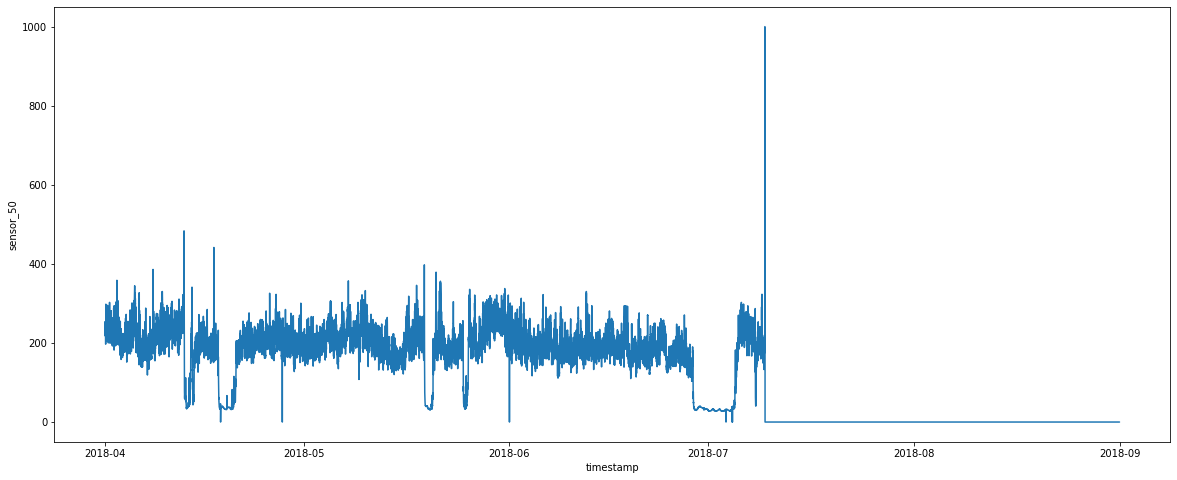

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
sns.set_style("darkgrid")
sns.lineplot(x = "timestamp", y = "sensor_50", data=data_scope_sensor_50_filled_na)

### Insight
#### It clearly shows the sensor_50 data was not present since some time - the chart indicates - it got broken?
#### Perhaps it is not going to be in the system or got removed permanently - hence we are going to remove this variable

#### For other columns - replace them with linear interpolation

In [ ]:
columns_to_impute = [colname for colname in data_scope.columns if ('sensor_' in colname) ]
columns_to_impute.remove('sensor_15')
columns_to_impute.remove('sensor_50')

#### Run interpolation and replace null values in data

In [ ]:

for colname in columns_to_impute:
  print("=========")
  # Create subset with the specific column
  code = "data_scope_"+colname+" = data_scope[['timestamp','"+colname+"']]"
  print(code)
  exec(code)
  # Run polynomial interpolation
  code = "data_scope_"+colname+"['"+colname+"_interpolate'] = data_scope['"+colname+"'].interpolate()"
  print(code)
  exec(code)
  code = "data_scope_"+colname+"=data_scope_"+colname+".drop('"+colname+"',axis = 1).rename(columns={'"+colname+"_interpolate':'"+colname+"'})"
  print(code)
  exec(code)
  code = "data_scope.update(data_scope_"+colname+")"
  print(code)
  exec(code)
  code = "del data_scope_"+colname
  exec(code)

data_scope_sensor_00 = data_scope[['timestamp','sensor_00']]
data_scope_sensor_00['sensor_00_interpolate'] = data_scope['sensor_00'].interpolate()
data_scope_sensor_00=data_scope_sensor_00.drop('sensor_00',axis = 1).rename(columns={'sensor_00_interpolate':'sensor_00'})
data_scope.update(data_scope_sensor_00)

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
data_scope_sensor_01 = data_scope[['timestamp','sensor_01']]
data_scope_sensor_01['sensor_01_interpolate'] = data_scope['sensor_01'].interpolate()
data_scope_sensor_01=data_scope_sensor_01.drop('sensor_01',axis = 1).rename(columns={'sensor_01_interpolate':'sensor_01'})
data_scope.update(data_scope_sensor_01)
data_scope_sensor_02 = data_scope[['timestamp','sensor_02']]
data_scope_sensor_02['sensor_02_interpolate'] = data_sc

In [ ]:
## Drop the two columns
data_scope = data_scope.drop(['sensor_15','sensor_50'],axis = 1)

#### Again check null value pct in data

In [ ]:
list_with_colname_blnks = []
for i in range(2,len(data_scope.columns)-6):
  colname = data_scope.columns[i]
#   print(colname)
  blank_rows = data_scope[(data_scope[colname] == '') | (data_scope[colname].isna())].shape[0]
 
  pct_of_blnks = blank_rows/data_scope.shape[0]

  col_pct_blnks = [colname,pct_of_blnks]
  list_with_colname_blnks.append(col_pct_blnks)
  blnk_pct_df = pd.DataFrame(list_with_colname_blnks,columns = ['colname','pct_of_blanks'])

In [ ]:
blnk_pct_df.sort_values('pct_of_blanks',ascending=False).head(15)

,colname,pct_of_blanks
0,sensor_00,0.0
1,sensor_01,0.0
28,sensor_29,0.0
29,sensor_30,0.0
30,sensor_31,0.0
31,sensor_32,0.0
32,sensor_33,0.0
33,sensor_34,0.0
34,sensor_35,0.0
35,sensor_36,0.0


#### Now all columns are imputed for nulls, hence create cleaned df

In [ ]:
data_scope_cleaned = data_scope

# 3. Feature Engineering and Selection

In [ ]:
base_feature_columns = ['sensor_00', 'sensor_01', 'sensor_02', 'sensor_03',
       'sensor_04', 'sensor_05', 'sensor_06', 'sensor_07', 'sensor_08',
       'sensor_09', 'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13',
       'sensor_14', 'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19',
       'sensor_20', 'sensor_21', 'sensor_22', 'sensor_23', 'sensor_24',
       'sensor_25', 'sensor_26', 'sensor_27', 'sensor_28', 'sensor_29',
       'sensor_30', 'sensor_31', 'sensor_32', 'sensor_33', 'sensor_34',
       'sensor_35', 'sensor_36', 'sensor_37', 'sensor_38', 'sensor_39',
       'sensor_40', 'sensor_41', 'sensor_42', 'sensor_43', 'sensor_44',
       'sensor_45', 'sensor_46', 'sensor_47', 'sensor_48', 'sensor_49',
       'sensor_51']

In [ ]:
base_feature_df = data_scope_cleaned[base_feature_columns]

### 3.1 Run correlation analysis and remove highly correlated features

In [ ]:

# Create correlation matrix
corr_matrix = base_feature_df[base_feature_columns].corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.90
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

# Drop features 
base_feature_df.drop(to_drop, axis=1, inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
final_feature_columns = ['sensor_00', 'sensor_01', 'sensor_02', 'sensor_03',
       'sensor_04', 'sensor_05', 'sensor_06', 'sensor_11', 'sensor_12',
       'sensor_13', 'sensor_14', 'sensor_27', 'sensor_28', 'sensor_29',
       'sensor_30', 'sensor_31', 'sensor_32', 'sensor_33', 'sensor_34',
       'sensor_35', 'sensor_36', 'sensor_37', 'sensor_38', 'sensor_39',
       'sensor_40', 'sensor_41', 'sensor_42', 'sensor_43', 'sensor_44',
       'sensor_45', 'sensor_46', 'sensor_47', 'sensor_48', 'sensor_49',
       'sensor_51']

In [ ]:
len(final_feature_columns)

Out[34]: 35

### Insight
##### So after correlation analysis and data cleansing - 35 features are remaining

### 3.2. Create next level dataset for feature expansion

In [ ]:
training_data = data_scope_cleaned[final_feature_columns]
training_data.insert(0, column='_c0',value = data_scope_cleaned['_c0'].values)
training_data.insert(0, column='timestamp',value = data_scope_cleaned['timestamp'].values)
training_data.insert(0, column='status_value',value = data_scope_cleaned['status_value'].values)

### 3.2.1. Create target variable

#### Define function to create binary status - take both broken and maintenance status as positive class.

### We are planning to predict the future, so we build target label as the status in next 10 minutes

In [ ]:
training_data['status_value_shift'] = training_data['status_value'].shift(-10)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:


def define_target(val):
  if val==1:
    target = 0
  else:
    target = 1
  return target


training_data['Target'] = training_data['status_value_shift'].apply(lambda x:define_target(x))


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### 3.2.2. Expand variables to take historical trend
#### Expand lag variables, moving average and ratio amongst them, for each sensor and apply lightgbm modelling
#### lag and moving average values for past [2,5,7,10,12,15,18,20] minutes time window
#### Ratio of lag value against moving average for each time window

In [ ]:
model_data = training_data[['_c0','timestamp','status_value','Target','sensor_00', 'sensor_01', 'sensor_02', 'sensor_03','sensor_04', 'sensor_05', 'sensor_06', 'sensor_11', 'sensor_12',
       'sensor_13', 'sensor_14', 'sensor_27', 'sensor_28', 'sensor_29',
       'sensor_30', 'sensor_31', 'sensor_32', 'sensor_33', 'sensor_34',
       'sensor_35', 'sensor_36', 'sensor_37', 'sensor_38', 'sensor_39',
       'sensor_40', 'sensor_41', 'sensor_42', 'sensor_43', 'sensor_44',
       'sensor_45', 'sensor_46', 'sensor_47', 'sensor_48', 'sensor_49',
       'sensor_51']]

### Create expansion in loop, for each sensor variable

In [ ]:
## For each sensor column
for colname in model_data.columns[4:]:
  print(colname)
  
  ## For each time window
  for window in [2,5,7,10,12,15,18,20]:
    
    ## lag variables
    code = "model_data['"+colname+"_lag_"+str(window)+"'] = model_data['"+colname+"'].shift("+str(window)+")"
    print(code)
    exec(code)

    ## moving average
    code = "model_data['"+colname+"_movav_"+str(window)+"'] = model_data['"+colname+"'].rolling("+str(window)+").mean()"
    print(code)
    exec(code)


    ## ratio variables
    code = "model_data['"+colname+"_ratio_movav_to_shift_"+str(window)+"'] = model_data['"+colname+"_lag_"+str(window)+"']/model_data['"+colname+"_movav_"+str(window)+"']"
    print(code)
    exec(code)
    

sensor_00
model_data['sensor_00_lag_2'] = model_data['sensor_00'].shift(2)
model_data['sensor_00_movav_2'] = model_data['sensor_00'].rolling(2).mean()
model_data['sensor_00_ratio_movav_to_shift_2'] = model_data['sensor_00_lag_2']/model_data['sensor_00_movav_2']
model_data['sensor_00_lag_5'] = model_data['sensor_00'].shift(5)
model_data['sensor_00_movav_5'] = model_data['sensor_00'].rolling(5).mean()
model_data['sensor_00_ratio_movav_to_shift_5'] = model_data['sensor_00_lag_5']/model_data['sensor_00_movav_5']
model_data['sensor_00_lag_7'] = model_data['sensor_00'].shift(7)
model_data['sensor_00_movav_7'] = model_data['sensor_00'].rolling(7).mean()
model_data['sensor_00_ratio_movav_to_shift_7'] = model_data['sensor_00_lag_7']/model_data['sensor_00_movav_7']
model_data['sensor_00_lag_10'] = model_data['sensor_00'].shift(10)
model_data['sensor_00_movav_10'] = model_data['sensor_00'].rolling(10).mean()
model_data['sensor_00_ratio_movav_to_shift_10'] = model_data['sensor_00_lag_10']/model_da

In [ ]:
model_data.replace([np.inf, -np.inf], 0, inplace=True)

#### define model input features list

In [ ]:
model_input_features = model_data.columns[4:]
model_input_features

Out[41]: Index(['sensor_00', 'sensor_01', 'sensor_02', 'sensor_03', 'sensor_04',
       'sensor_05', 'sensor_06', 'sensor_11', 'sensor_12', 'sensor_13',
       ...
       'sensor_51_ratio_movav_to_shift_12', 'sensor_51_lag_15',
       'sensor_51_movav_15', 'sensor_51_ratio_movav_to_shift_15',
       'sensor_51_lag_18', 'sensor_51_movav_18',
       'sensor_51_ratio_movav_to_shift_18', 'sensor_51_lag_20',
       'sensor_51_movav_20', 'sensor_51_ratio_movav_to_shift_20'],
      dtype='object', length=875)

#4. Modelling

### 4.1. Train-test segregation
##### As it is a time-series data, we will take the data till first 4 failures in training and keep the data with last 3 failures as testing

In [ ]:
train = model_data[(model_data['timestamp']<='2018-06-15 00:00:00')]
test = model_data[(model_data['timestamp']>'2018-06-15 00:00:00')]

In [ ]:
train['Target'].value_counts()

Out[43]: 0    102026
1      5975
Name: Target, dtype: int64

In [ ]:
test['Target'].value_counts()

Out[44]: 0    103800
1      8519
Name: Target, dtype: int64

In [ ]:
X_train = train
X_test = test
train_y = train['Target'].values
test_y = test['Target'].values

### 4.2. Encoding and scaling

#### Label encode target data

In [ ]:
enc = LabelEncoder()
train_y_encoded = enc.fit_transform(train_y)
test_y_encoded = enc.fit_transform(test_y)

#### Use training data to fit a scaler and apply that to both training and testing data

In [ ]:
scaler = MinMaxScaler()
scaler.fit(X_train[model_input_features])
X_train_scaled = scaler.transform(X_train[model_input_features])
X_test_scaled = scaler.transform(X_test[model_input_features])

### Define function for prediction metrices

In [ ]:
def prediction_metrices(model,X_test,X_test_scaled,y_test,most_important_numeric_features_final):

  '''
  The function will take inputs as:
    1. A trained model
    2. Unscaled dataframe with training or testing data, , depending on if we are measuring performance of training or testing
    3. Scaled data of training or testing data, depending on if we are measuring performance of training or testing
    4. Train or test targets as a list same size of the input dataframe
    5. The list of features required for model
    
    
  The function will return outputs as:
    1. Input dataset appended with prediction result, probability value and ranked by descending class_1 probability
    2. Feature importance dataframe for lightgbm model with rank and weight of each input feature
    3. ROC-AUC score for model predictions
    
  '''
  
  ## Predict class, probability of class_1 and append to input dataframe
  pred_test = model.predict(X_test_scaled)
  pred_prob = model.predict_proba(X_test_scaled)[:, 1]
  results = X_test.copy()
  results['y_pred'] = pred_test
  results['y_prob'] = pred_prob

  results['y_true']=y_test
  y_true = y_test
  y_pred = pred_test
    
  ## Ranked output with cumulative capture
  results = results.sort_values('y_prob', ascending=False)
  results['y_true_cumsum'] = results['y_true'].cumsum(axis = 0)
  results['row_count'] = range(1,results.shape[0]+1,1)
    
  ## ROC-AUC 
  roc_auc = roc_auc_score(y_true, pred_prob)

  ## Feature importance dataframe with rank and weightages of each input feature
  feat_imp_df = pd.DataFrame(list(zip(range(len(list(model.feature_importances_))), list(model.feature_importances_))),columns=['index','feat_imp'])
  feat_imp_df['feature_name'] = most_important_numeric_features_final
  feat_imp_df_sorted = feat_imp_df.sort_values('feat_imp',ascending=False)
    
  return results,feat_imp_df_sorted,roc_auc

### As the dataset has very few positive class with respect to negatives, we have to use a scaling factor in modelling

In [ ]:
scaling_factor = int(train['Target'].value_counts()[0]/train['Target'].value_counts()[1])

###4.3. Memory management before model training and next steps

In [ ]:
del device_data_pd
del maint_data_base_sorted
del maint_data_base_sorted_details
del data_scope
del base_feature_df
del training_data

In [ ]:
gc.collect()

Out[51]: 850

#### Set random state for model reproducibility

In [ ]:
random_state = 999


###4.4. Model training job

In [ ]:

model = lgb.LGBMClassifier(metric='f1',random_seed=random_state,n_jobs=1,max_bin =50,scale_pos_weight  = scaling_factor)
model.fit(X_train_scaled, train_y_encoded, verbose=2)



'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Out[53]: LGBMClassifier(max_bin=50, metric='f1', n_jobs=1, random_seed=999,
               scale_pos_weight=17)

### Prediction of train data

In [ ]:

results_train,feature_imp_sorted,roc_auc_train = prediction_metrices(model,X_train,X_train_scaled,train_y,model_input_features)

In [ ]:
roc_auc_train

Out[55]: 1.0

### Prediction of testing data

In [ ]:
results,feature_imp_sorted,roc_auc = prediction_metrices(model,X_test,X_test_scaled,test_y,model_input_features)

In [ ]:
roc_auc

Out[57]: 0.9981903428604901

#### Print basic metric - TP, FP, TN, FN, FPR and FNR

In [ ]:
tn, fp, fn, tp = confusion_matrix(list(results['y_true'].values), list(results['y_pred'].values)).ravel()
print('TP Count = ',tp)
print('FP Count = ',fp)
print('FN Count = ',fn)
print('TN Count = ',tn)


print('False Positive Rate:',fp/(tp+fp))
print('False Negative Rate:',fn/(tn+fn))

TP Count =  8419
FP Count =  266
FN Count =  100
TN Count =  103534
False Positive Rate: 0.030627518710420264
False Negative Rate: 0.0009649342879749889


### Insight
##### Model seems to have high precision and recall
##### BUT
##### Precision or Recall will not be sufficient to check model's effectiveness
##### We have to check whether model is able to predict future failure, while currently device is in good state

In [ ]:
results.columns

Out[59]: Index(['_c0', 'timestamp', 'status_value', 'Target', 'sensor_00', 'sensor_01',
       'sensor_02', 'sensor_03', 'sensor_04', 'sensor_05',
       ...
       'sensor_51_movav_18', 'sensor_51_ratio_movav_to_shift_18',
       'sensor_51_lag_20', 'sensor_51_movav_20',
       'sensor_51_ratio_movav_to_shift_20', 'y_pred', 'y_prob', 'y_true',
       'y_true_cumsum', 'row_count'],
      dtype='object', length=884)

# 5. Model Effectiveness Analysis

#### Check overall scores against actual status - over timeline

Out[60]: Text(0, 0.5, 'Device Status')

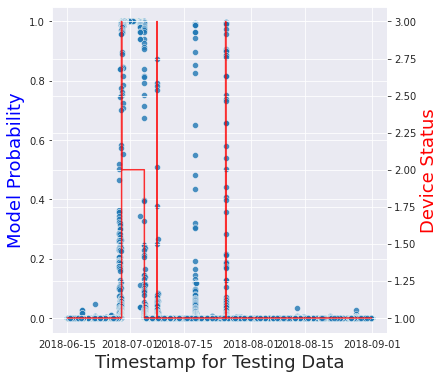

In [ ]:
# results = val_results_joined_base.sort_values(by='timestamp')
fig, ax = plt.subplots(figsize=(6,6))
sns.set_style("darkgrid")
sns.scatterplot( x = 'timestamp',y = "y_prob", data=results,alpha=0.8)
ax2 = plt.twinx()
sns.lineplot(x = 'timestamp',y = "status_value", data=results, color="r",alpha = 0.8,ax=ax2)
ax.set_xlabel('Timestamp for Testing Data',size = 18)
ax.set_ylabel('Model Probability',size = 18,color = 'b')
ax2.set_ylabel('Device Status',size = 18,color = 'r')

### Insight
#### Looks like model is predicting around actual breakdown periods, however, have some misses

###5.1.  Have a closure look over the breakdown periods in testing data - Is the model able to predicy the failures in sometime early?

#### Breakdown – 1 (Display  ~7.5 days around that)
#### 28th June 22:01:00 , maintenance duration = ~6 days

Boolean Series key will be reindexed to match DataFrame index.
Out[61]: Text(0, 0.5, 'Device Status')

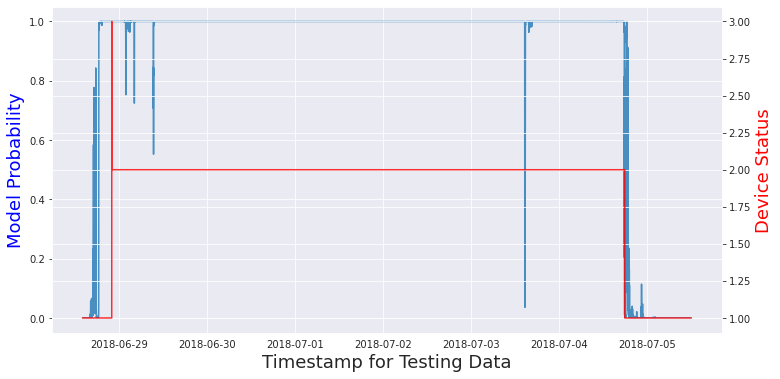

In [ ]:
results_to_plot = results.sort_values(by='timestamp')[(results['timestamp']>'2018-06-28 14:00:00') & (results['timestamp']<'2018-07-05 12:00:00') ]
# results = val_results_joined_base.sort_values(by='timestamp')
fig, ax = plt.subplots(figsize=(12,6))
sns.set_style("darkgrid")
sns.lineplot( x = 'timestamp',y = "y_prob", data=results_to_plot,alpha=0.8)
ax2 = plt.twinx()
sns.lineplot(x = 'timestamp',y = "status_value", data=results_to_plot, color="r",alpha = 0.8,ax=ax2)
ax.set_xlabel('Timestamp for Testing Data',size = 18)
ax.set_ylabel('Model Probability',size = 18,color = 'b')
ax2.set_ylabel('Device Status',size = 18,color = 'r')

### Model predicted breakdown ~5 hours before

#### Breakdown – 2 (Display  ~1.5 hours around that)
#### 7th July 00:12:00 , maintenance duration  ~40 minutes

Boolean Series key will be reindexed to match DataFrame index.
Out[62]: Text(0, 0.5, 'Device Status')

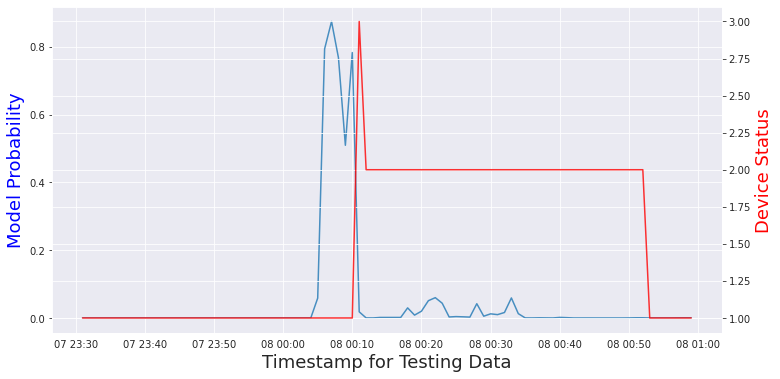

In [ ]:
results_to_plot = results.sort_values(by='timestamp')[(results['timestamp']>'2018-07-07 23:30:00') & (results['timestamp']<'2018-07-08 01:00:00') ]
# results = val_results_joined_base.sort_values(by='timestamp')
fig, ax = plt.subplots(figsize=(12,6))
sns.set_style("darkgrid")
sns.lineplot( x = 'timestamp',y = "y_prob", data=results_to_plot,alpha=0.8)
ax2 = plt.twinx()
sns.lineplot(x = 'timestamp',y = "status_value", data=results_to_plot, color="r",alpha = 0.8,ax=ax2)
ax.set_xlabel('Timestamp for Testing Data',size = 18)
ax.set_ylabel('Model Probability',size = 18,color = 'b')
ax2.set_ylabel('Device Status',size = 18,color = 'r')

### Model predicted breakdown ~4 minutes before

#### Breakdown – 3 (Display  ~3 hours around that)
#### 25th July 14:01:00 , maintenance duration ~1.25 hours

Boolean Series key will be reindexed to match DataFrame index.
Out[63]: Text(0, 0.5, 'Device Status')

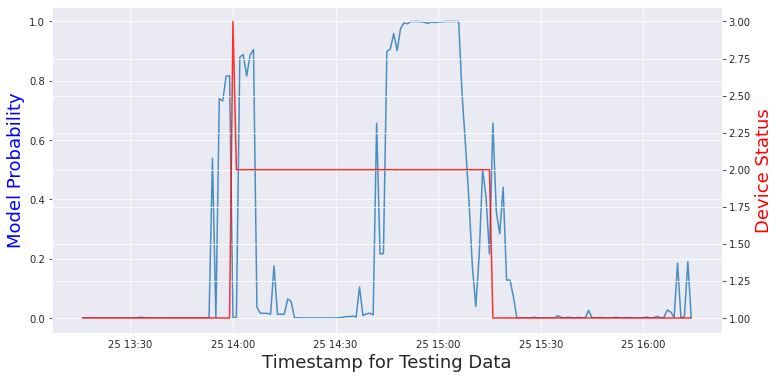

In [ ]:
results_to_plot = results.sort_values(by='timestamp')[(results['timestamp']>'2018-07-25 13:15:00') & (results['timestamp']<'2018-07-25 16:15:00') ]
# results = val_results_joined_base.sort_values(by='timestamp')
fig, ax = plt.subplots(figsize=(12,6))
sns.set_style("darkgrid")
sns.lineplot( x = 'timestamp',y = "y_prob", data=results_to_plot,alpha=0.8)
ax2 = plt.twinx()
sns.lineplot(x = 'timestamp',y = "status_value", data=results_to_plot, color="r",alpha = 0.8,ax=ax2)
ax.set_xlabel('Timestamp for Testing Data',size = 18)
ax.set_ylabel('Model Probability',size = 18,color = 'b')
ax2.set_ylabel('Device Status',size = 18,color = 'r')

#### Model predicted breakdown ~6 minutes before

### Insight
#### Model is able to predict all failures, in advance, sometimes few minutes, sometimes few hours before it happens actually, depending on the severity of the issue

## Insight
##  Longer the maintenance window, more severe the issue

## More severe the issue – model predicts more early with higher risk score

## Hence, looking at the model prediction score – we can estimate the severity of the issue

# 5.2. Measure models performance on predicting failures in future

## Calculate what percentage of triggers , raised by the model while system is in normal state, captures at least one actual failure within the next X minutes window

In [ ]:
## define empty list of logs
list_of_logs=[]

## Define a high threshold for model predictions
thresh = 0.8

## For each time window in future starting from 2 hours to 5 days
for future_hours in range(2,122,2):
    print('============')
    print(future_hours)
    print('============')
    
    ## Window = hours*60 minutes
    window = int(future_hours*60)
    
    
    ## Create working dataset
    results_to_work = results[['timestamp','status_value','y_prob']].sort_values('timestamp')
    
    ## Create feature to identify maximum status value within next 'window' minutes
    results_to_work['status_value_max_within_future_period'] = results_to_work.sort_values(by='timestamp',ascending=False)['status_value'].rolling(window).max()
    
    results_to_work = results_to_work.sort_values(by='timestamp')
    
    
    ## Identify predicted positives (i.e, triggers above probability threshold) while current status is 'Normal'
    pred_pos = results_to_work[(results_to_work['y_prob']>=thresh) & (results_to_work['status_value']==1)]
    count_of_triggers = pred_pos.shape[0]
    print('Trigger Count=',count_of_triggers)
    
    ## Calculate true_pos, i.e, having at least one actual failure within window period
    true_pos_within_future = pred_pos[pred_pos['status_value_max_within_future_period']>1]
    count_of_actual_failures = true_pos_within_future.shape[0]
    print('TP Count=',count_of_actual_failures)
    
    ## Create log record
    record_for_log = (thresh,future_hours,count_of_triggers,count_of_actual_failures)
    
    ## Append log record to list of logs 
    list_of_logs.append(record_for_log)
    
## After finishing the process, take the list of logs and create a dataframe with them
model_metric_df = pd.DataFrame(list_of_logs,columns=['thresh','future_hours','count_of_triggers','count_of_actual_failures'])
    
## Calculate accuracy metric by dividing count of actual failures by total count of triggers above threshold
model_metric_df['accuracy_of_triggers_in_future_window'] = model_metric_df['count_of_actual_failures']/model_metric_df['count_of_triggers']


    

2
Trigger Count= 256
TP Count= 122
4
Trigger Count= 256
TP Count= 216
6
Trigger Count= 256
TP Count= 217
8
Trigger Count= 256
TP Count= 217
10
Trigger Count= 256
TP Count= 219
12
Trigger Count= 256
TP Count= 219
14
Trigger Count= 256
TP Count= 219
16
Trigger Count= 256
TP Count= 219
18
Trigger Count= 256
TP Count= 219
20
Trigger Count= 256
TP Count= 219
22
Trigger Count= 256
TP Count= 219
24
Trigger Count= 256
TP Count= 219
26
Trigger Count= 256
TP Count= 219
28
Trigger Count= 256
TP Count= 219
30
Trigger Count= 256
TP Count= 219
32
Trigger Count= 256
TP Count= 219
34
Trigger Count= 256
TP Count= 219
36
Trigger Count= 256
TP Count= 219
38
Trigger Count= 256
TP Count= 219
40
Trigger Count= 256
TP Count= 219
42
Trigger Count= 256
TP Count= 219
44
Trigger Count= 256
TP Count= 219
46
Trigger Count= 256
TP Count= 219
48
Trigger Count= 256
TP Count= 219
50
Trigger Count= 256
TP Count= 219
52
Trigger Count= 256
TP Count= 219
54
Trigger Count= 256
TP Count= 219
56
Trigger Count= 256
TP Count= 

In [ ]:
model_metric_df

,thresh,future_hours,count_of_triggers,count_of_actual_failures,accuracy_of_triggers_in_future_window
0,0.8,2,256,122,0.476562
1,0.8,4,256,216,0.843750
2,0.8,6,256,217,0.847656
3,0.8,8,256,217,0.847656
4,0.8,10,256,219,0.855469
5,0.8,12,256,219,0.855469
6,0.8,14,256,219,0.855469
7,0.8,16,256,219,0.855469
8,0.8,18,256,219,0.855469
9,0.8,20,256,219,0.855469


### Plot data to show accuracy against time window

Out[66]: Text(0.5, 0, 'Percentage of total triggers \nwhile device is in normal state')

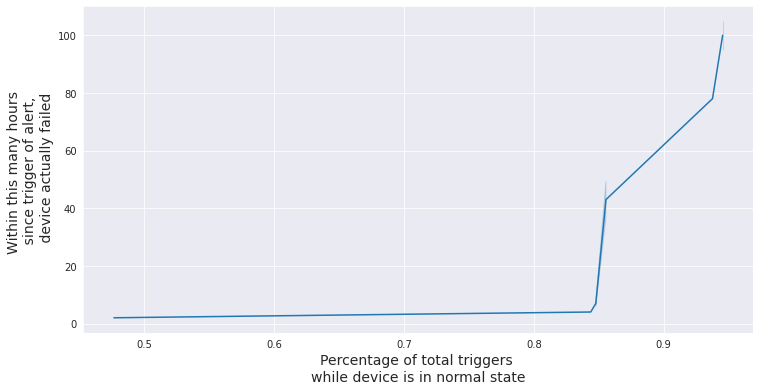

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
sns.set_style("darkgrid")

sns.lineplot( y = 'future_hours',x = "accuracy_of_triggers_in_future_window", data=model_metric_df)

ax.set_ylabel('Within this many hours \n since trigger of alert, \n device actually failed',size = 14)
ax.set_xlabel('Percentage of total triggers \nwhile device is in normal state',size = 14)

### Insight

#### While system is running in normal status, model can predict an actual failure
  - #####Within next 4 hours, with ~85% accuracy
  - #####Within next 3.25 days, with 95% accuracy

#6. Model Explainability

### Model can give explanation in terms of feature weightage, for each predicted trigger, telling  against about what are the top reasons model thinks that the device is going to fail

In [ ]:
import shap

### 6.2. Global Model Explainability

### Create a SHAP explainer for the trained lightGBM model

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train[model_input_features])

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


### Plot global level top predictors - identified during training. However, these has less value while interpreting about individual predictions

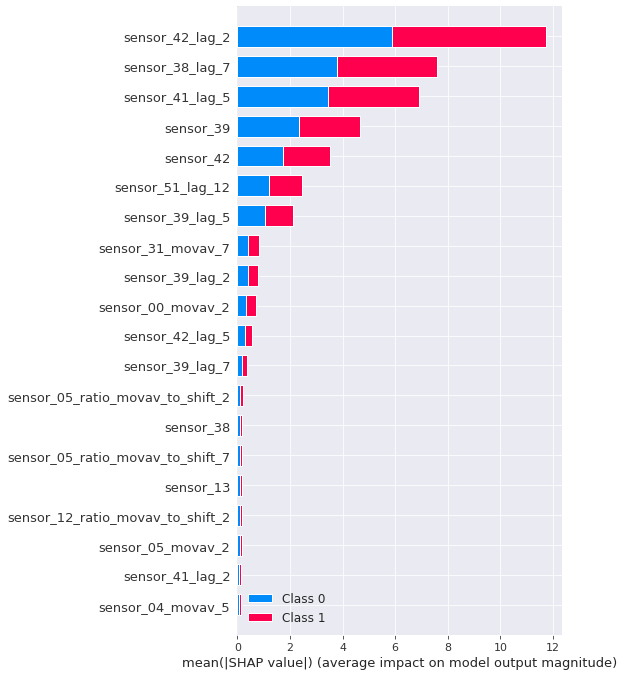

In [ ]:
shap.summary_plot(shap_values, X_train[model_input_features])

###6.2. Local explainability for individual predictions

##### Select few data points with high probability values before each of the 3 actual failure

In [ ]:
X_test_selected = results[results['_c0'].isin([127980,127981,141127, 141128,166437,166438])]

X_test_selected[['_c0','timestamp','y_prob','status_value','Target']]

,_c0,timestamp,y_prob,status_value,Target
127981,127981,2018-06-28 21:01:00,0.999958,1,0
127980,127980,2018-06-28 21:00:00,0.999958,1,0
141127,141127,2018-07-08 00:07:00,0.874430,1,1
166438,166438,2018-07-25 13:58:00,0.815376,1,1
141128,141128,2018-07-08 00:08:00,0.767357,1,1
166437,166437,2018-07-25 13:57:00,0.731988,1,1


### Scale and fit the explainer

In [ ]:
# Scale
X_test_selected_scaled = scaler.transform(X_test_selected[model_input_features])

# Fits the explainer
explainer = shap.Explainer(model.predict, X_test_selected_scaled,max_evals=2000)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test_selected_scaled)
# shap.plots.bar(shap_values[0])

### Show shap explainability weights for some of the predictions

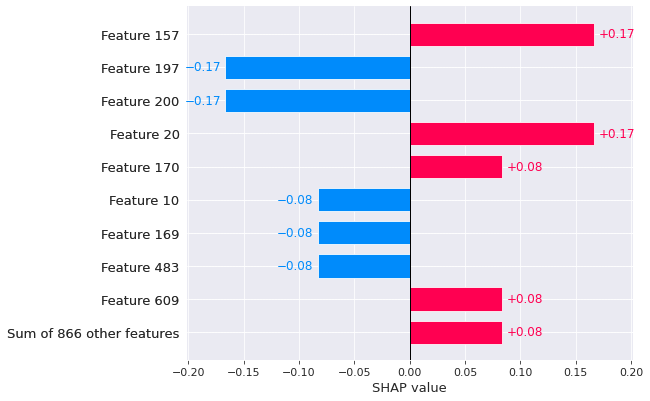

In [ ]:
shap.plots.bar(shap_values[0])

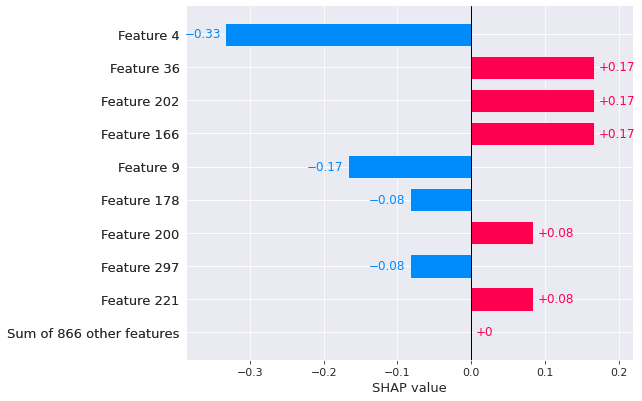

In [ ]:
shap.plots.bar(shap_values[2])

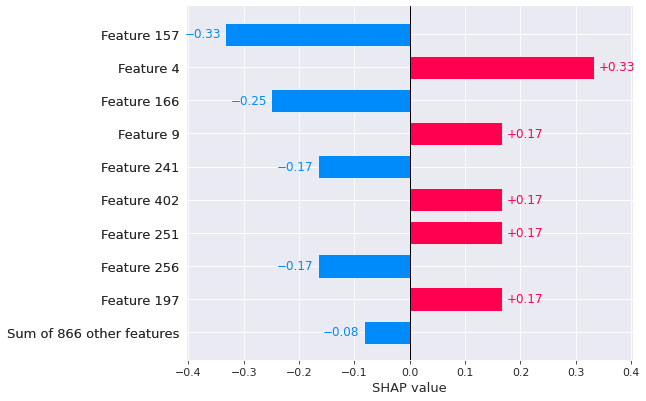

In [ ]:

shap.plots.bar(shap_values[5])

#7. Final Conclusion

### Model can predict all failures in advance, and with sufficient high accuracy (85%+)
### Model can explain the reason for each of the triggers, which sensor value or trend triggerred the alert